In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/PROYECTOS_DIPLOMADO/VISION

/content/drive/.shortcut-targets-by-id/1t2J8Q1IpvHK3pPOnBHLyYRJH9Ugc1A9N/PROYECTOS_DIPLOMADO/VISION


In [ ]:
%cd urban-street_-tree-classification-DatasetNinja

/content/drive/.shortcut-targets-by-id/1t2J8Q1IpvHK3pPOnBHLyYRJH9Ugc1A9N/PROYECTOS_DIPLOMADO/VISION/urban-street_-tree-classification-DatasetNinja


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class UrbanStreetTreeDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.imgs = sorted(os.listdir(img_dir))
        self.class_to_idx = self._find_classes()  # Mapeo de nombres de clases a índices

    def _find_classes(self):
        classes = set()
        for img_name in self.imgs:
            ann_path = os.path.join(self.ann_dir, img_name + '.json')
            with open(ann_path, 'r') as f:
                annotation = json.load(f)
            tag_name = annotation['tags'][0]['name']
            classes.add(tag_name)
        classes = sorted(classes)
        return {cls: idx for idx, cls in enumerate(classes)}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, img_name + '.json')

        # Leer imagen
        image = Image.open(img_path).convert("RGB")

        # Leer anotación
        with open(ann_path, 'r') as f:
            annotation = json.load(f)

        # Extraer la clase de la anotación
        tag_name = annotation['tags'][0]['name']
        label = self.class_to_idx[tag_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader

In [ ]:
class PreprocessedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

# Load preprocessed datasets from Google Drive
preprocessed_train_data = torch.load('preprocessed_train_dataset.pth')
preprocessed_val_data = torch.load('preprocessed_val_dataset.pth')
preprocessed_test_data = torch.load('preprocessed_test_dataset.pth')

train_dataset = PreprocessedDataset(preprocessed_train_data)
val_dataset = PreprocessedDataset(preprocessed_val_data)
test_dataset = PreprocessedDataset(preprocessed_test_data)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Usar un modelo preentrenado como ResNet
class TreeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TreeClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Crear una instancia del modelo
num_classes = 23
model = TreeClassifier(num_classes)

# Después de algunas épocas, descongelar más capas
#for param in model.model.parameters():
#    param.requires_grad = True

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.3MB/s]


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LambdaLR

# Cambiar el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Añadir un scheduler para reducir el learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
#scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)
#scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, scheduler=None, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    early_stopping = EarlyStopping(patience=7, min_delta=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if scheduler:
            scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
# Train the model and get the loss and accuracy values
trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=25)

# Save the loss and accuracy values
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}, '/content/drive/MyDrive/training_results_resnet.pth')


Epoch 1/25, Train Loss: 1.3620, Train Accuracy: 0.5873, Val Loss: 2.1067, Val Accuracy: 0.5104
Epoch 2/25, Train Loss: 0.6516, Train Accuracy: 0.8029, Val Loss: 2.3747, Val Accuracy: 0.4481
Epoch 3/25, Train Loss: 0.4394, Train Accuracy: 0.8642, Val Loss: 1.4156, Val Accuracy: 0.6598
Epoch 4/25, Train Loss: 0.3080, Train Accuracy: 0.9023, Val Loss: 1.4636, Val Accuracy: 0.6556
Epoch 5/25, Train Loss: 0.1787, Train Accuracy: 0.9460, Val Loss: 2.3242, Val Accuracy: 0.4378
Epoch 6/25, Train Loss: 0.1437, Train Accuracy: 0.9590, Val Loss: 1.2802, Val Accuracy: 0.7012
Epoch 7/25, Train Loss: 0.1238, Train Accuracy: 0.9616, Val Loss: 0.7195, Val Accuracy: 0.7842
Epoch 8/25, Train Loss: 0.0653, Train Accuracy: 0.9800, Val Loss: 0.5251, Val Accuracy: 0.8485
Epoch 9/25, Train Loss: 0.1303, Train Accuracy: 0.9579, Val Loss: 0.7775, Val Accuracy: 0.7905
Epoch 10/25, Train Loss: 0.1237, Train Accuracy: 0.9590, Val Loss: 1.2676, Val Accuracy: 0.7054
Epoch 11/25, Train Loss: 0.1501, Train Accuracy: 

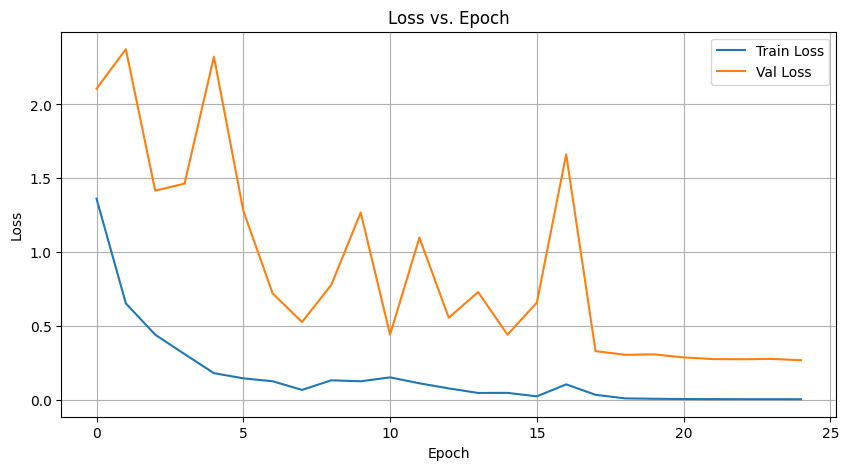

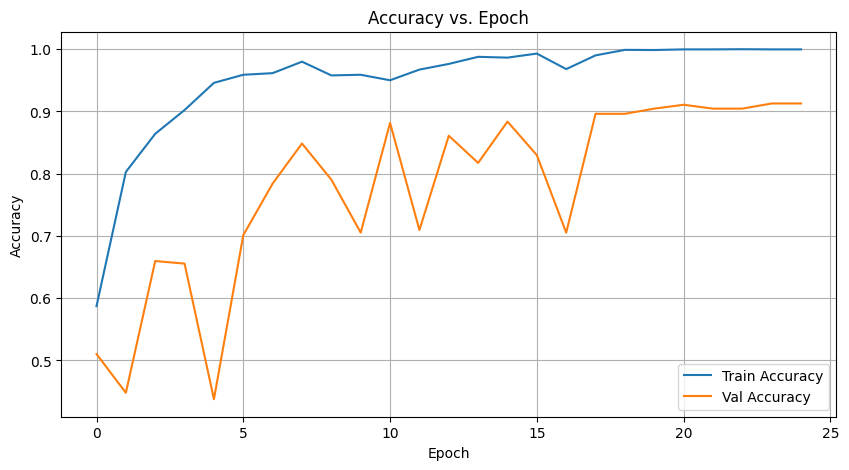

In [ ]:
import matplotlib.pyplot as plt

# Load the loss and accuracy values
results = torch.load('/content/drive/MyDrive/training_results_resnet.pth')
train_losses = results['train_losses']
val_losses = results['val_losses']
train_accuracies = results['train_accuracies']
val_accuracies = results['val_accuracies']

# Plot Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    all_indices = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(softmax_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(softmax_outputs.cpu().numpy())
            all_indices.extend([i] * inputs.size(0))  # Track the indices

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_indices = np.array(all_indices)

    accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    print(f'Test Accuracy: {accuracy:.4f}')

    return all_preds, all_labels, all_probs, all_indices

In [ ]:
preds, labels, probs, indices = evaluate_model(trained_model, test_loader)

NameError: name 'trained_model' is not defined

In [ ]:
torch.save(trained_model.state_dict(), 'resnet_tree_weights_jimm.pth')

In [ ]:
torch.save(trained_model, 'resnet_tree_model_jimm.pth')

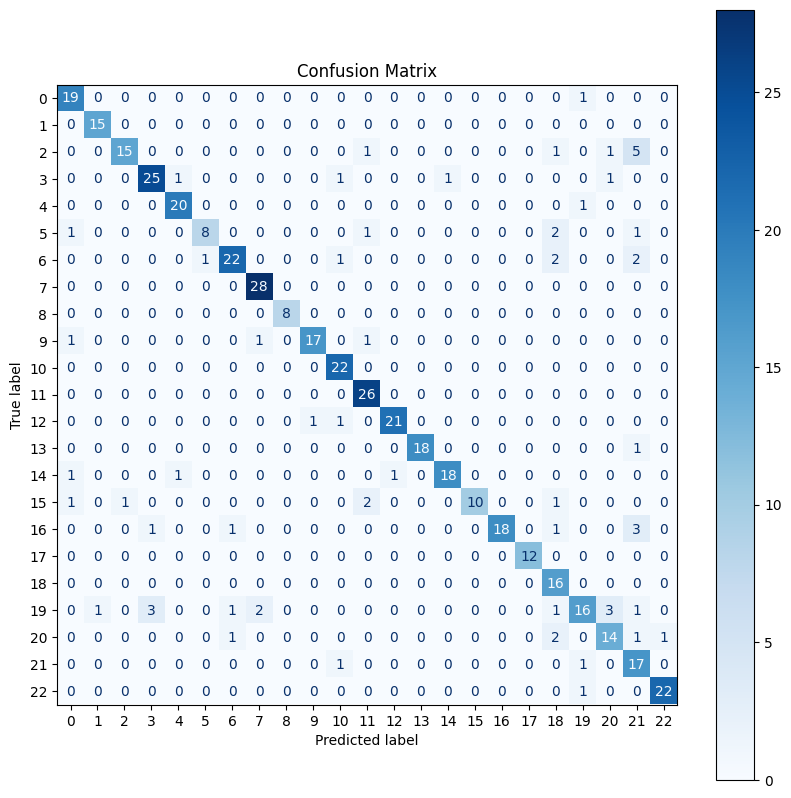

In [ ]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(10, 10))  # Set the figsize to make the plot larger
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the ax to disp.plot()
plt.title('Confusion Matrix')
plt.show()


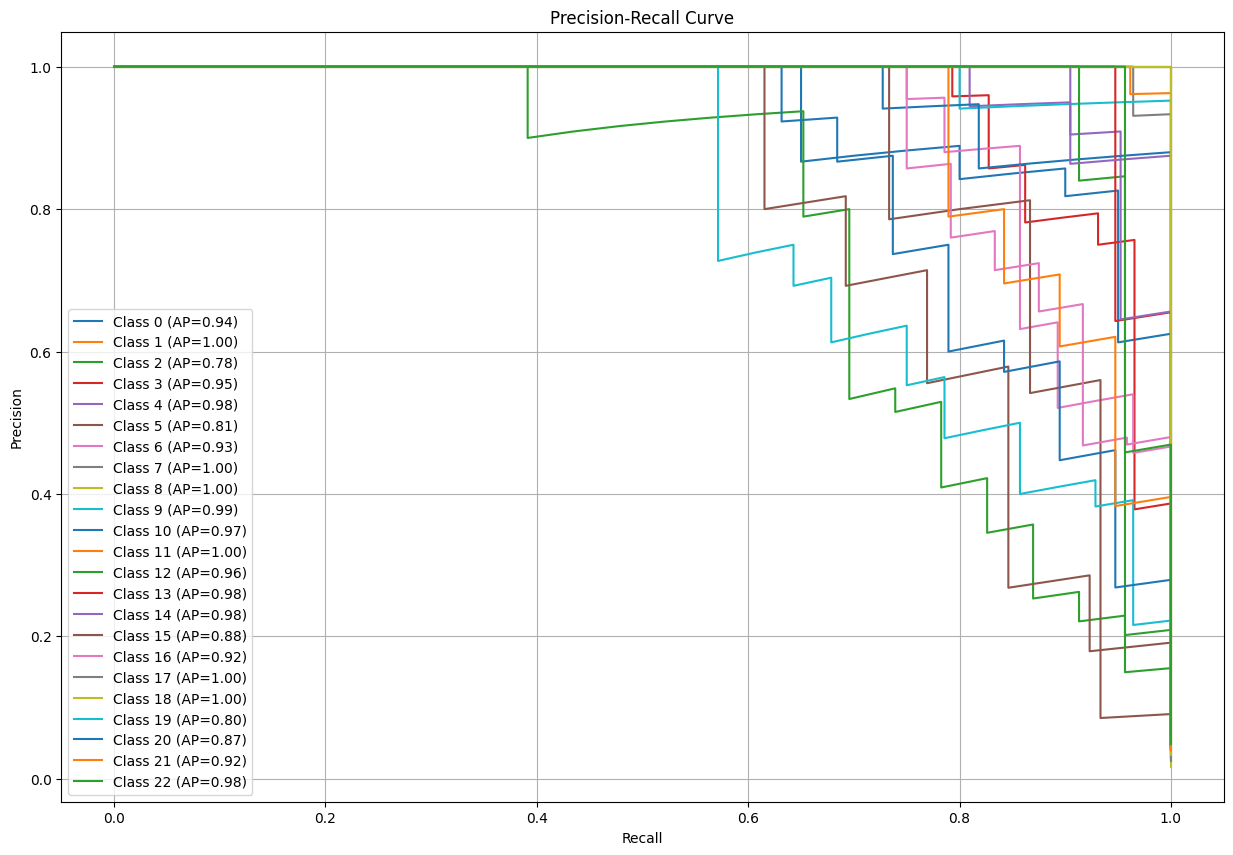

In [ ]:
# Precision-Recall Curve
plt.figure(figsize=(15, 10))
num_classes = probs.shape[1]
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve((labels == i).astype(int), probs[:, i])
    average_precision = average_precision_score((labels == i).astype(int), probs[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP={average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

plt.figure(figsize=(15, 10))

# Determinar el número de clases a partir de las probabilidades
num_classes = probs.shape[1]

for i in range(num_classes):
    # Calcular precisión, recall y umbrales para la clase i
    precision, recall, _ = precision_recall_curve((labels == i).astype(int), probs[:, i])

    # Calcular el promedio de precisión para la clase i
    average_precision = average_precision_score((labels == i).astype(int), probs[:, i])

    # Calcular F1-score para cada punto
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Añadir un pequeño epsilon para evitar división por cero

    # Encontrar el F1-score máximo
    max_f1_index = f1_scores.argmax()
    max_f1 = f1_scores[max_f1_index]

    # Graficar la curva Precision-Recall
    plt.plot(recall, precision, label=f'Class {i} (AP={average_precision:.2f}, F1={max_f1:.2f})')

# Etiquetas y formato del gráfico
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with F1-scores')
plt.legend(loc='best')
plt.grid(True)
plt.show()

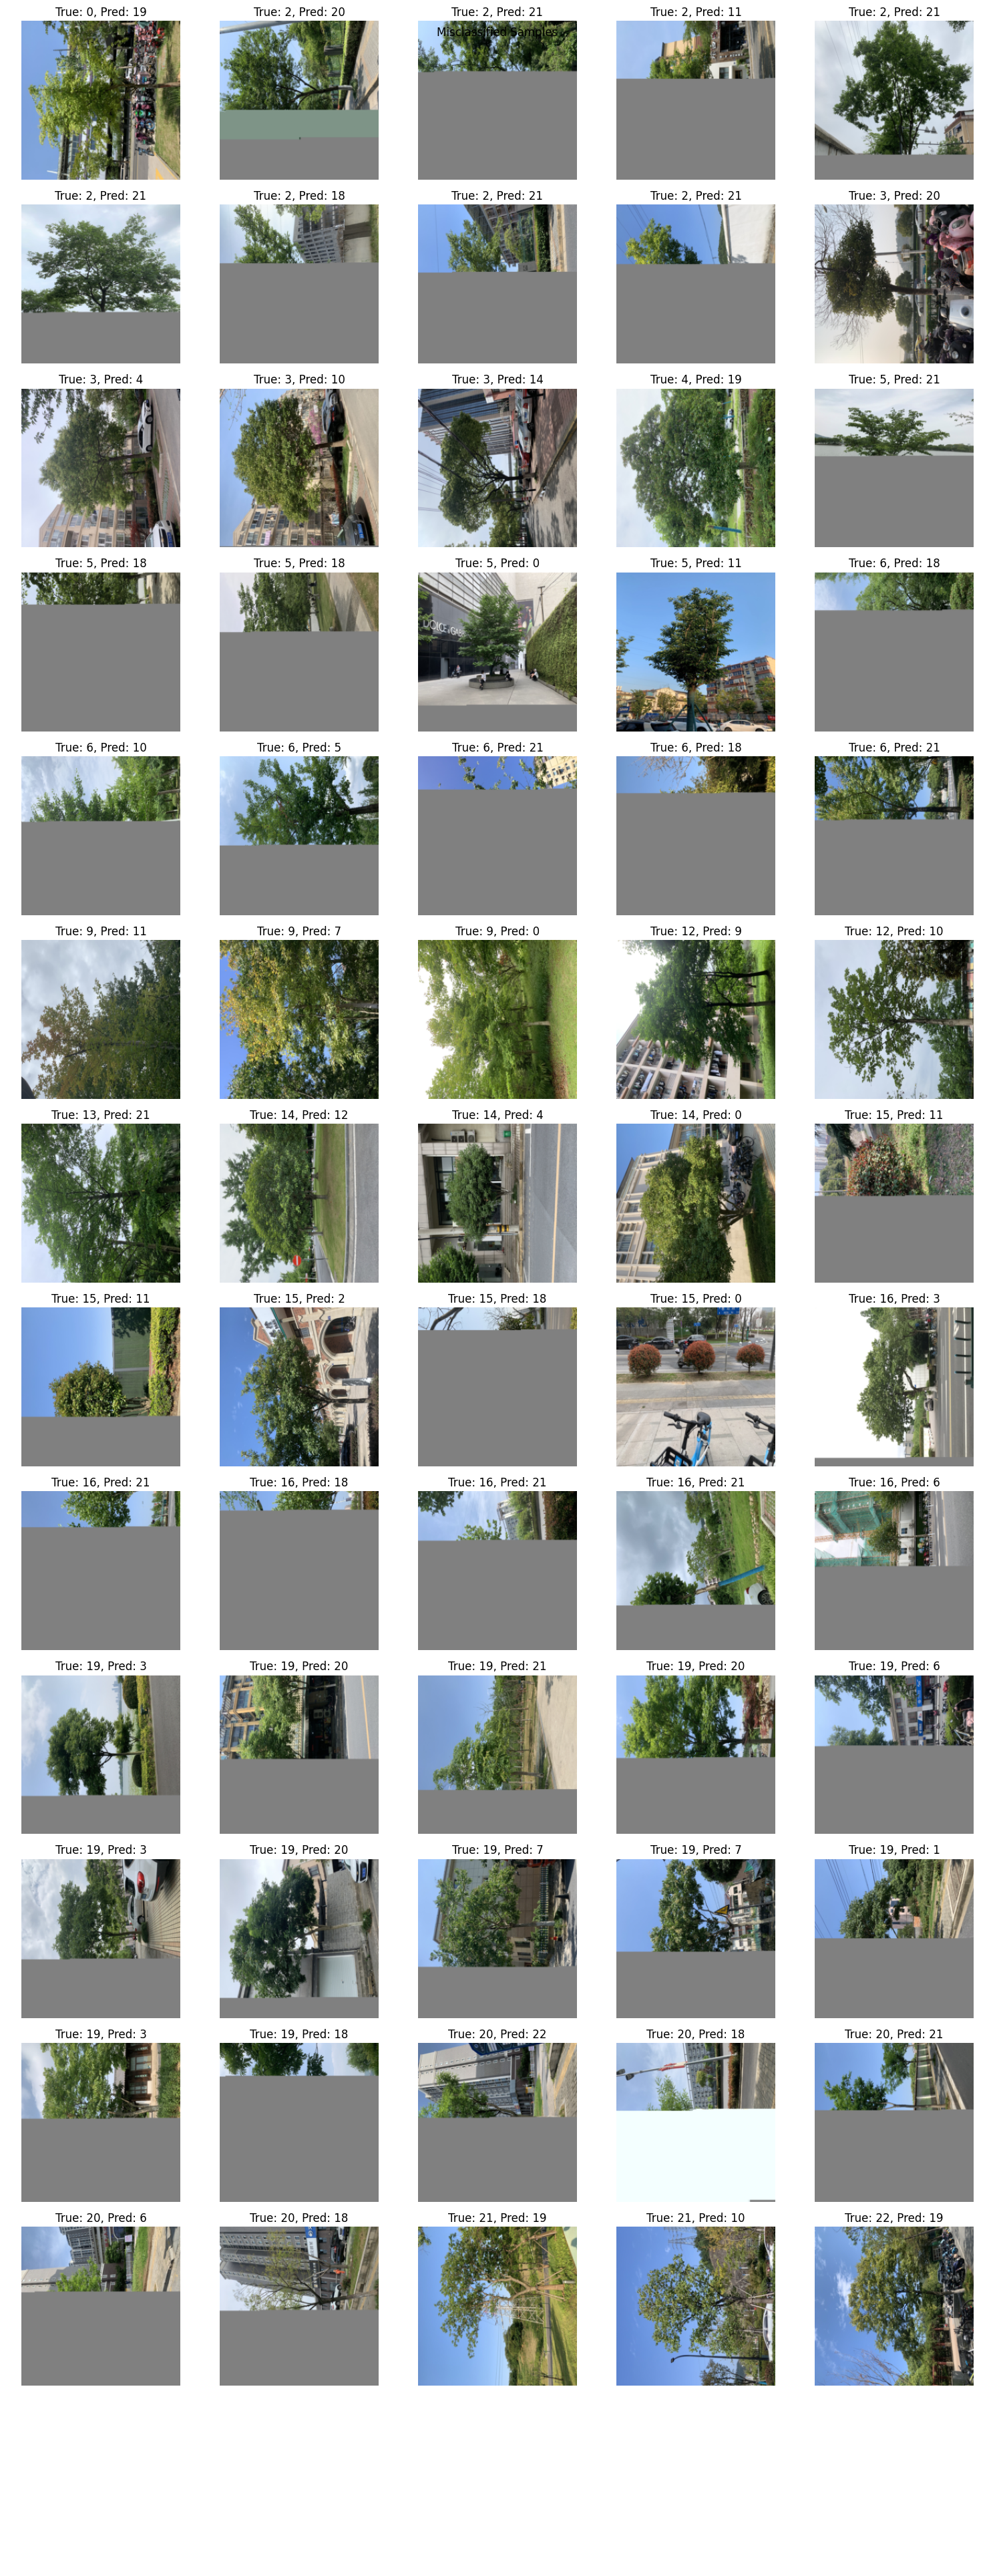

In [ ]:
# Example to demonstrate the use of indices (e.g., plotting misclassified samples)
misclassified_indices = np.where(preds != labels)[0]
misclassified_samples = [test_loader.dataset[idx] for idx in misclassified_indices]

def plot_misclassified_images(dataset, indices, preds, labels, title):
    fig, axes = plt.subplots(len(indices) // 5 + 1, 5, figsize=(15, len(indices) // 5 * 3))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        image, true_label = dataset[idx][:2]

        # Convert tensor to NumPy array and ensure correct format
        image = image.permute(1, 2, 0).cpu().numpy()

        # Normalize image values to [0, 1] range if necessary
        if image.max() > 1:
            image = image / 255.0

        pred_label = preds[idx]
        ax.imshow(image)
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis('off')

    # Hide any remaining empty subplots
    for ax in axes[len(indices):]:
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_misclassified_images(test_loader.dataset, misclassified_indices, preds, labels, "Misclassified Samples")